# Autoregressive Distributed Lag (ARDL) models

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [2]:
from statsmodels.datasets.danish_data import load
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

data = load().data
data = data[["lrm", "lry", "ibo", "ide"]]
data.tail()

,lrm,lry,ibo,ide
period,,,,
1986-07-01,12.056189,6.098992,0.111500,0.067941
1986-10-01,12.071628,6.080706,0.114267,0.075396
1987-01-01,12.027952,6.061175,0.119333,0.076653
1987-04-01,12.039788,6.063730,0.117333,0.076259
1987-07-01,12.015294,6.050830,0.118967,0.075163


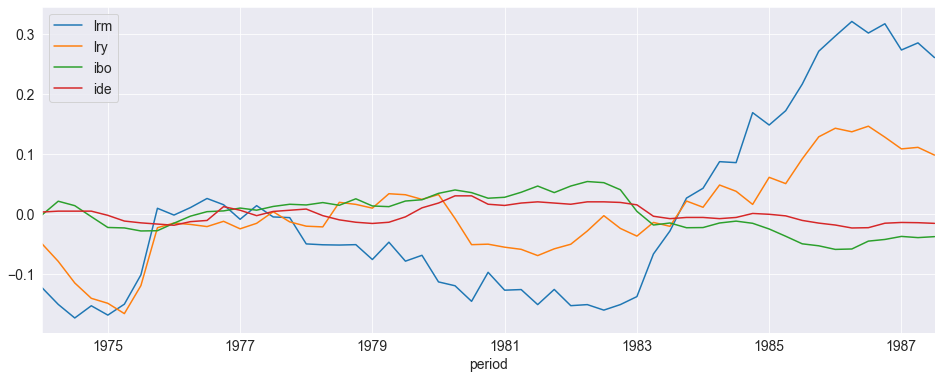

In [3]:
_ = (data - data.mean()).plot()

In [4]:
sel_res = ardl_select_order(
    data.lrm, 3, data[["lry", "ibo", "ide"]], 3, ic="aic", trend="c"
)
sel_res.model.ardl_order

(3, 1, 3, 2)

In [5]:
res = sel_res.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                    lrm   No. Observations:                   55
Model:               ARDL(3, 1, 3, 2)   Log Likelihood                 139.513
Method:               Conditional MLE   S.D. of innovations              0.017
Date:                Tue, 07 Sep 2021   AIC                           -251.026
Time:                        12:27:14   BIC                           -223.708
Sample:                    10-01-1974   HQIC                          -240.553
                         - 07-01-1987                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6202      0.568      4.615      0.000       1.472       3.769
lrm.L1         0.3192      0.137      2.336      0.025       0.043       0.596
lrm.L2         0.5326      0.132      4.024      0.000       0.265       0.800
lrm.L3        -0.2687      0.102     -2.631      0.012      -0.475      -0.062
lry.L0         0.6728      0.131      5.129      0.000       0.407       0.938
lry.L1        -0.2574      0.147     -1.749      0.088      -0.555       0.040
ibo.L0        -1.0785      0.322     -3.353      0.002      -1.729      -0.428
ibo.L1        -0.1062      0.586     -0.181      0.857      -1.291       1.079
ibo.L2         0.2877      0.569      0.505      0.616      -0.863       1.439
ibo.L3        -0.9947      0.393     -2.534      0.015      -1.789      -0.201
ide.L0         0.1255      0.554      0.226      0.822      -0.996       1.247
ide.L1        -0.3280      0.721     -0.455      0.652      -1.787       1.131
ide.L2         1.4079      0.552      2.550      0.015       0.291       2.524
==============================================================================
"""

In [6]:
sel_res = ardl_select_order(
    data.lrm, 3, data[["lry", "ibo", "ide"]], 3, ic="bic", trend="c", glob=True
)
sel_res.model.ardl_order

(3, 0, 3, 2)

In [7]:
sel_res.model.ar_lags

[1, 2, 3]

In [8]:
sel_res.model.dl_lags

{'lry': [0], 'ibo': [0, 3], 'ide': [2]}

In [9]:
for i, val in enumerate(sel_res.bic.head(10)):
    print(f"{i+1}: {val}")

1: ((1, 2, 3), {'lry': (0,), 'ibo': (0, 3), 'ide': (2,)})
2: ((1, 2, 3), {'lry': (0, 1), 'ibo': (0, 3), 'ide': (2,)})
3: ((2,), {'lry': (0,), 'ibo': (0, 3), 'ide': (3,)})
4: ((1, 2, 3), {'lry': (0, 2), 'ibo': (0, 3), 'ide': (2,)})
5: ((2,), {'lry': (0, 2), 'ibo': (0, 3), 'ide': (2,)})
6: ((2,), {'lry': (0, 3), 'ibo': (0, 3), 'ide': (2,)})
7: ((2, 3), {'lry': (0,), 'ibo': (0, 3), 'ide': (2,)})
8: ((1, 2, 3), {'lry': (0,), 'ibo': (0, 3), 'ide': (2, 3)})
9: ((2,), {'lry': (0,), 'ibo': (0, 3), 'ide': (2, 3)})
10: ((1, 2), {'lry': (0,), 'ibo': (0, 3), 'ide': (3,)})


In [10]:
res = ARDL(
    data.lrm, 2, data[["lry", "ibo", "ide"]], {"lry": 1, "ibo": 2, "ide": 3}, trend="c"
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                    lrm   No. Observations:                   55
Model:               ARDL(2, 1, 2, 3)   Log Likelihood                 136.252
Method:               Conditional MLE   S.D. of innovations              0.019
Date:                Tue, 07 Sep 2021   AIC                           -246.504
Time:                        12:27:17   BIC                           -220.890
Sample:                    10-01-1974   HQIC                          -236.654
                         - 07-01-1987                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4440      0.546      4.479      0.000       1.342       3.546
lrm.L1         0.2695      0.139      1.944      0.059      -0.011       0.550
lrm.L2         0.3409      0.114      2.993      0.005       0.111       0.571
lry.L0         0.6344      0.145      4.368      0.000       0.341       0.928
lry.L1        -0.2426      0.159     -1.527      0.134      -0.563       0.078
ibo.L0        -1.1316      0.359     -3.157      0.003      -1.856      -0.408
ibo.L1         0.1056      0.640      0.165      0.870      -1.186       1.397
ibo.L2        -0.8347      0.497     -1.679      0.101      -1.839       0.170
ide.L0         0.2849      0.614      0.464      0.645      -0.954       1.524
ide.L1         0.0433      0.805      0.054      0.957      -1.582       1.669
ide.L2         0.4429      0.770      0.575      0.568      -1.112       1.998
ide.L3         0.3671      0.515      0.713      0.480      -0.673       1.408
==============================================================================
"""

In [11]:
res = ARDL(
    data.lrm,
    2,
    data[["lry", "ibo", "ide"]],
    {"lry": 1, "ibo": 2, "ide": 3},
    trend="c",
    causal=True,
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                    lrm   No. Observations:                   55
Model:               ARDL(2, 1, 2, 3)   Log Likelihood                 121.130
Method:               Conditional MLE   S.D. of innovations              0.025
Date:                Tue, 07 Sep 2021   AIC                           -222.260
Time:                        12:27:17   BIC                           -202.557
Sample:                    10-01-1974   HQIC                          -214.683
                         - 07-01-1987                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3885      0.696      3.434      0.001       0.987       3.790
lrm.L1         0.4294      0.169      2.538      0.015       0.088       0.770
lrm.L2         0.2777      0.139      2.003      0.051      -0.002       0.557
lry.L1         0.2064      0.139      1.481      0.146      -0.074       0.487
ibo.L1        -1.2787      0.467     -2.736      0.009      -2.221      -0.337
ibo.L2        -0.3403      0.568     -0.600      0.552      -1.484       0.804
ide.L1        -0.1234      0.746     -0.165      0.869      -1.627       1.380
ide.L2         0.5001      0.978      0.511      0.612      -1.471       2.472
ide.L3         0.6106      0.656      0.931      0.357      -0.711       1.933
==============================================================================
"""

In [12]:
from statsmodels.tsa.api import UECM

sel_res = ardl_select_order(
    data.lrm, 3, data[["lry", "ibo", "ide"]], 3, ic="aic", trend="c"
)

ecm = UECM.from_ardl(sel_res.model)
ecm_res = ecm.fit()
ecm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              UECM Model Results                              
==============================================================================
Dep. Variable:                  D.lrm   No. Observations:                   55
Model:               UECM(3, 1, 3, 2)   Log Likelihood                 139.513
Method:               Conditional MLE   S.D. of innovations             11.756
Date:                Tue, 07 Sep 2021   AIC                           -251.026
Time:                        12:27:17   BIC                           -223.708
Sample:                    10-01-1974   HQIC                          -240.553
                         - 07-01-1987                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6202      0.568      4.615      0.000       1.472       3.769
lrm.L1        -0.4169      0.092     -4.548      0.000      -0.602      -0.231
lry.L1         0.4154      0.118      3.532      0.001       0.177       0.653
ibo.L1        -1.8917      0.391     -4.837      0.000      -2.683      -1.101
ide.L1         1.2053      0.447      2.697      0.010       0.301       2.109
D.lrm.L1      -0.2639      0.102     -2.590      0.013      -0.470      -0.058
D.lrm.L2       0.2687      0.102      2.631      0.012       0.062       0.475
D.lry.L0       0.6728      0.131      5.129      0.000       0.407       0.938
D.ibo.L0      -1.0785      0.322     -3.353      0.002      -1.729      -0.428
D.ibo.L1       0.7070      0.469      1.508      0.140      -0.241       1.655
D.ibo.L2       0.9947      0.393      2.534      0.015       0.201       1.789
D.ide.L0       0.1255      0.554      0.226      0.822      -0.996       1.247
D.ide.L1      -1.4079      0.552     -2.550      0.015      -2.524      -0.291
==============================================================================
"""

In [13]:
ecm_res.ci_summary()

,coef,std err,t,P>|t|,[0.025,0.975]
const,-6.2857,0.772,-8.143,0.000,-7.847,-4.724
lrm.L1,1.0000,0,nan,nan,1.000,1.000
lry.L1,-0.9965,0.124,-8.041,0.000,-1.247,-0.746
ibo.L1,4.5381,0.520,8.722,0.000,3.486,5.591
ide.L1,-2.8915,0.995,-2.906,0.004,-4.904,-0.879


<AxesSubplot:title={'center':'Cointegrating Error'}, xlabel='period'>

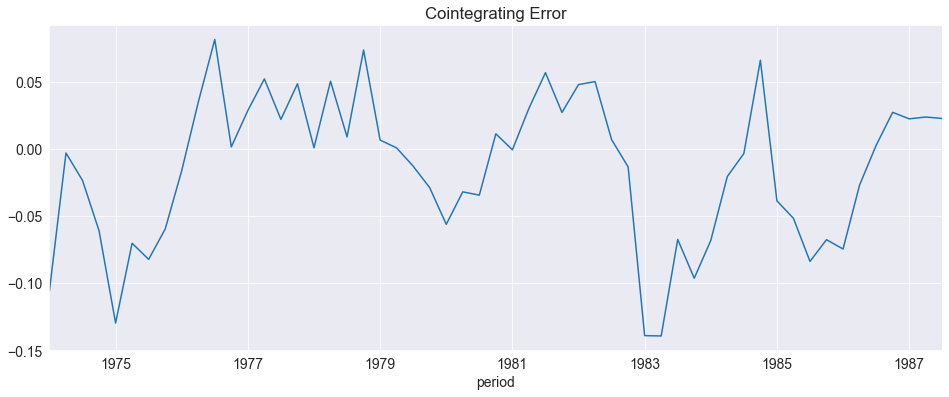

In [14]:
ecm_res.ci_resids.plot(title="Cointegrating Error")

In [15]:
ecm = UECM(data.lrm, 2, data[["lry", "ibo", "ide"]], 2, seasonal=True)
seasonal_ecm_res = ecm.fit()
seasonal_ecm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                UECM Model Results                                
==================================================================================
Dep. Variable:                      D.lrm   No. Observations:                   55
Model:             Seas. UECM(2, 2, 2, 2)   Log Likelihood                 150.609
Method:                   Conditional MLE   S.D. of innovations             11.753
Date:                    Tue, 07 Sep 2021   AIC                           -269.218
Time:                            12:27:17   BIC                           -237.694
Sample:                        07-01-1974   HQIC                          -257.096
                             - 07-01-1987                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6501      0.429      3.848      0.000       0.782       2.518
s(2,4)         0.0328      0.011      2.943      0.006       0.010       0.055
s(3,4)         0.0153      0.008      1.965      0.057      -0.000       0.031
s(4,4)         0.0460      0.009      5.060      0.000       0.028       0.064
lrm.L1        -0.2543      0.072     -3.530      0.001      -0.400      -0.108
lry.L1         0.2437      0.100      2.444      0.019       0.042       0.446
ibo.L1        -1.2113      0.297     -4.083      0.000      -1.812      -0.611
ide.L1         0.6537      0.384      1.701      0.097      -0.124       1.432
D.lrm.L1       0.0377      0.156      0.241      0.811      -0.279       0.354
D.lry.L0       0.4624      0.121      3.827      0.000       0.218       0.707
D.lry.L1       0.0457      0.130      0.351      0.727      -0.218       0.309
D.ibo.L0      -0.9562      0.312     -3.062      0.004      -1.588      -0.324
D.ibo.L1       0.4133      0.360      1.148      0.258      -0.315       1.142
D.ide.L0      -0.3945      0.505     -0.781      0.440      -1.417       0.628
D.ide.L1      -0.1430      0.466     -0.307      0.761      -1.086       0.800
==============================================================================
"""

In [16]:
seasonal_ecm_res.ci_summary()

,coef,std err,t,P>|t|,[0.025,0.975]
const,-6.4899,1.155,-5.621,0.000,-8.827,-4.152
"s(2,4)",-0.1291,0.066,-1.956,0.050,-0.263,0.005
"s(3,4)",-0.0603,0.039,-1.545,0.122,-0.139,0.019
"s(4,4)",-0.1810,0.071,-2.562,0.010,-0.324,-0.038
lrm.L1,1.0000,0,nan,nan,1.000,1.000
lry.L1,-0.9585,0.187,-5.137,0.000,-1.336,-0.581
ibo.L1,4.7641,0.826,5.768,0.000,3.092,6.436
ide.L1,-2.5708,1.461,-1.760,0.078,-5.529,0.387


<AxesSubplot:title={'center':'Cointegrating Error with Seasonality'}, xlabel='period'>

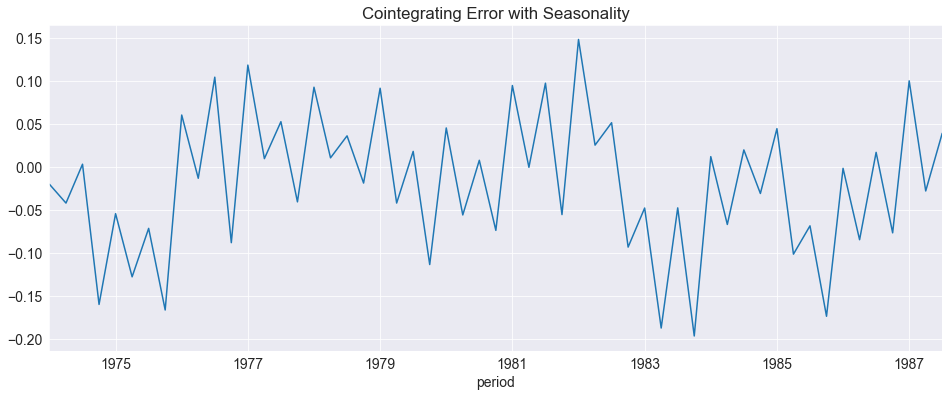

In [17]:
seasonal_ecm_res.ci_resids.plot(title="Cointegrating Error with Seasonality")

In [18]:
greene = pd.read_fwf("http://www.stern.nyu.edu/~wgreene/Text/Edition7/TableF5-2.txt")
greene.head()

,Year,qtr,realgdp,realcons,realinvs realgovt realdpi cpi_u M1,tbilrate,unemp,pop,infl,realint
0,1950.0,1.0,1610.5,1058.9,198.1 361.0 1186.1 70.6 110.20,1.12,6.4,149.461,0.0000,0.0000
1,1950.0,2.0,1658.8,1075.9,220.4 366.4 1178.1 71.4 111.75,1.17,5.6,150.260,4.5071,-3.3404
2,1950.0,3.0,1723.0,1131.0,239.7 359.6 1196.5 73.2 112.95,1.23,4.6,151.064,9.9590,-8.7290
3,1950.0,4.0,1753.9,1097.6,271.8 382.5 1210.0 74.9 113.93,1.35,4.2,151.871,9.1834,-7.8301
4,1951.0,1.0,1773.5,1122.8,242.9 421.9 1207.9 77.3 115.08,1.40,3.5,152.393,12.6160,-11.2160


In [19]:
index = pd.to_datetime(
    greene.Year.astype("int").astype("str")
    + "Q"
    + greene.qtr.astype("int").astype("str")
)
greene.index = index
greene.index.freq = greene.index.inferred_freq
greene.head()

,Year,qtr,realgdp,realcons,realinvs realgovt realdpi cpi_u M1,tbilrate,unemp,pop,infl,realint
1950-01-01,1950.0,1.0,1610.5,1058.9,198.1 361.0 1186.1 70.6 110.20,1.12,6.4,149.461,0.0000,0.0000
1950-04-01,1950.0,2.0,1658.8,1075.9,220.4 366.4 1178.1 71.4 111.75,1.17,5.6,150.260,4.5071,-3.3404
1950-07-01,1950.0,3.0,1723.0,1131.0,239.7 359.6 1196.5 73.2 112.95,1.23,4.6,151.064,9.9590,-8.7290
1950-10-01,1950.0,4.0,1753.9,1097.6,271.8 382.5 1210.0 74.9 113.93,1.35,4.2,151.871,9.1834,-7.8301
1951-01-01,1951.0,1.0,1773.5,1122.8,242.9 421.9 1207.9 77.3 115.08,1.40,3.5,152.393,12.6160,-11.2160


In [20]:
greene["c"] = np.log(greene.realcons)
greene["g"] = np.log(greene.realgdp)

In [21]:
sel_res = ardl_select_order(
    greene.c, 8, greene[["g"]], 8, trend="c", seasonal=True, ic="aic"
)
ardl = sel_res.model
ardl.ardl_order

(5, 1)

In [22]:
res = ardl.fit(use_t=True)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                      c   No. Observations:                  204
Model:               Seas. ARDL(5, 1)   Log Likelihood                 747.939
Method:               Conditional MLE   S.D. of innovations              0.006
Date:                Tue, 07 Sep 2021   AIC                          -1471.878
Time:                        12:27:19   BIC                          -1432.358
Sample:                    04-01-1951   HQIC                         -1455.883
                         - 10-01-2000                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0586      0.028     -2.103      0.037      -0.113      -0.004
s(2,4)        -0.0001      0.001     -0.087      0.930      -0.002       0.002
s(3,4)         0.0012      0.001      1.026      0.306      -0.001       0.004
s(4,4)         0.0003      0.001      0.296      0.768      -0.002       0.003
c.L1           0.8545      0.064     13.263      0.000       0.727       0.982
c.L2           0.2588      0.082      3.151      0.002       0.097       0.421
c.L3          -0.1566      0.072     -2.190      0.030      -0.298      -0.016
c.L4          -0.1941      0.070     -2.754      0.006      -0.333      -0.055
c.L5           0.1695      0.048      3.495      0.001       0.074       0.265
g.L0           0.5476      0.048     11.350      0.000       0.452       0.643
g.L1          -0.4757      0.051     -9.311      0.000      -0.576      -0.375
==============================================================================
"""

In [23]:
uecm = UECM.from_ardl(ardl)
uecm_res = uecm.fit()
uecm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              UECM Model Results                              
==============================================================================
Dep. Variable:                    D.c   No. Observations:                  204
Model:               Seas. UECM(5, 1)   Log Likelihood                 747.939
Method:               Conditional MLE   S.D. of innovations              7.909
Date:                Tue, 07 Sep 2021   AIC                          -1471.878
Time:                        12:27:19   BIC                          -1432.358
Sample:                    04-01-1951   HQIC                         -1455.883
                         - 10-01-2000                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0586      0.028     -2.103      0.037      -0.113      -0.004
s(2,4)        -0.0001      0.001     -0.087      0.930      -0.002       0.002
s(3,4)         0.0012      0.001      1.026      0.306      -0.001       0.004
s(4,4)         0.0003      0.001      0.296      0.768      -0.002       0.003
c.L1          -0.0679      0.029     -2.378      0.018      -0.124      -0.012
g.L1           0.0719      0.030      2.373      0.019       0.012       0.132
D.c.L1        -0.0776      0.059     -1.309      0.192      -0.194       0.039
D.c.L2         0.1812      0.053      3.415      0.001       0.077       0.286
D.c.L3         0.0246      0.049      0.498      0.619      -0.073       0.122
D.c.L4        -0.1695      0.048     -3.495      0.001      -0.265      -0.074
D.g.L0         0.5476      0.048     11.350      0.000       0.452       0.643
==============================================================================
"""

In [24]:
uecm_res.ci_summary()

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.8621,0.113,7.599,0.000,0.638,1.086
"s(2,4)",0.0015,0.017,0.087,0.930,-0.033,0.036
"s(3,4)",-0.0177,0.019,-0.935,0.350,-0.055,0.020
"s(4,4)",-0.0051,0.017,-0.294,0.769,-0.040,0.029
c.L1,1.0000,0,nan,nan,1.000,1.000
g.L1,-1.0590,0.013,-82.236,0.000,-1.084,-1.034


In [25]:
uecm = UECM(greene.c, 3, greene[["g"]], 3, trend="c", seasonal=True)
uecm_res = uecm.fit()
uecm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              UECM Model Results                              
==============================================================================
Dep. Variable:                    D.c   No. Observations:                  204
Model:               Seas. UECM(3, 3)   Log Likelihood                 739.794
Method:               Conditional MLE   S.D. of innovations              7.901
Date:                Tue, 07 Sep 2021   AIC                          -1455.588
Time:                        12:27:19   BIC                          -1415.948
Sample:                    10-01-1950   HQIC                         -1439.548
                         - 10-01-2000                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1102      0.029     -3.767      0.000      -0.168      -0.053
s(2,4)      4.659e-07      0.001      0.000      1.000      -0.003       0.003
s(3,4)         0.0012      0.001      0.929      0.354      -0.001       0.004
s(4,4)         0.0003      0.001      0.205      0.838      -0.002       0.003
c.L1          -0.1189      0.030     -3.903      0.000      -0.179      -0.059
g.L1           0.1265      0.032      3.919      0.000       0.063       0.190
D.c.L1        -0.1577      0.070     -2.260      0.025      -0.295      -0.020
D.c.L2         0.2337      0.069      3.402      0.001       0.098       0.369
D.g.L0         0.5651      0.052     10.877      0.000       0.463       0.668
D.g.L1         0.0477      0.064      0.749      0.455      -0.078       0.173
D.g.L2        -0.1902      0.059     -3.229      0.001      -0.306      -0.074
==============================================================================
"""

In [26]:
uecm_res.ci_summary()

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.9267,0.066,14.063,0.000,0.797,1.057
"s(2,4)",-3.917e-06,0.011,-0.000,1.000,-0.021,0.021
"s(3,4)",-0.0099,0.011,-0.902,0.367,-0.031,0.012
"s(4,4)",-0.0022,0.011,-0.205,0.838,-0.023,0.019
c.L1,1.0000,0,nan,nan,1.000,1.000
g.L1,-1.0635,0.008,-134.481,0.000,-1.079,-1.048


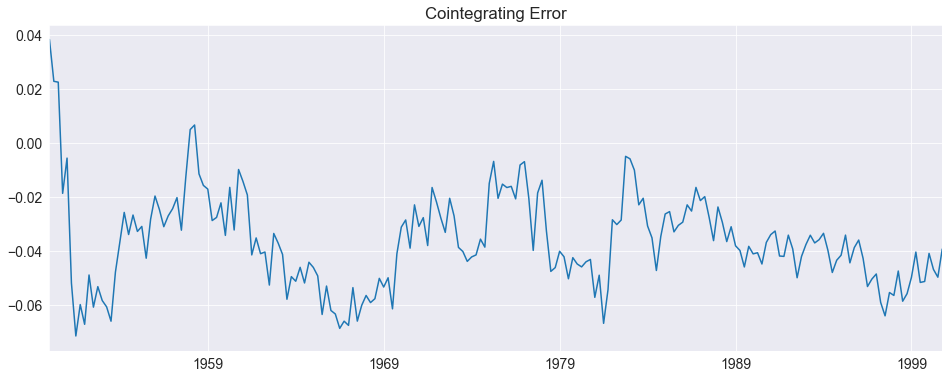

In [27]:
_ = uecm_res.ci_resids.plot(title="Cointegrating Error")